In [1]:
### Spectral Clustering Illustration (Handwritten Digits) 

In [2]:
# modules
import numpy as np
import pandas as pd
from sklearn.metrics.pairwise import euclidean_distances 
import matplotlib.pyplot as plt
from matplotlib import cm
import scipy.linalg as la 
from sklearn.cluster import AgglomerativeClustering
from sklearn.mixture import GaussianMixture
from sklearn.cluster import spectral_clustering

In [3]:
# read data set (here consisting of 1,000 digits 4 [first half of the data], 
# and 1,000 digits 8 [second half of the data])
#
# labels are known, but they are not used for constructing the clustering 
# (but they are used for validation purposes)

dir = '../data/'

X = np.array(pd.read_csv(dir + "digits_X.txt", sep='\t', header=None))
[n, d] = np.shape(X)
print(d) # 784 features --- 28 x 28 pixel images
labels = np.array(pd.read_csv(dir + "digits_labels.txt", sep=' ', header=None))
print(labels)

784
[[0]
 [0]
 [0]
 ...
 [1]
 [1]
 [1]]


In [4]:
### compute normalized weight matrix for spectral clustring 

# compute normalized squared Euclidean distances
Droot = euclidean_distances(X)/np.sqrt(d)
D = Droot**2

### insert the above squared distances into Gaussian kernel, and normalize 
W = np.exp(-D / 0.05)
s = np.sqrt(np.sum(W, 1))
Wnorm = W / s[np.newaxis,:] / s[:,np.newaxis]

#plt.imshow(Wnorm, cmap=cm.gray, interpolation='nearest', aspect = 'auto')
#plt.colorbar()

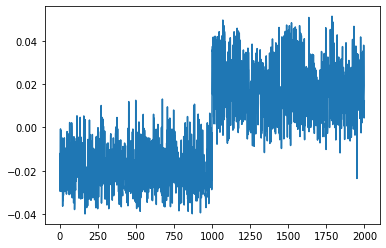

In [6]:
#### d)

# compute normalized eigenvector of Wtilde corresponding to its maximum eigenvalue
snorm = s / np.linalg.norm(s)

# power iteration with deflation
def power_iteration(A, num_simulations: int):
    # Ideally choose a random vector
    # To decrease the chance that our vector
    # Is orthogonal to the eigenvector
    b_k = np.random.rand(A.shape[1])

    for _ in range(num_simulations):
        # calculate the matrix-by-vector product Ab
        b_k1 = np.dot(A, b_k)
        
        b_k2 = b_k1 - snorm * np.dot(snorm, b_k1)

        # calculate the norm
        b_k2_norm = np.linalg.norm(b_k2)

        # re normalize the vector
        b_k = b_k2 / b_k2_norm

    return b_k

vhat = power_iteration(Wnorm, 100)

# plotting eigenvector (note that the first 1,000 correspond to class 4, remaining 1,000 to class 8)
plt.plot(vhat)

In [8]:
# double check with eigendecomposition
#[vals1, vec1] = la.eigh(Wnorm)
# np.sum(vhat * vec1[:,1998])
#np.sum(vhat * np.dot(Wnorm, vhat))
#vals1[1998]


# solve 1-d k-means problem
ixsort = np.argsort(vhat) 
vhat_sort = vhat[ixsort]

sum1 = np.cumsum(vhat_sort)
sum2 = np.sum(vhat_sort) - sum1
ss1 = np.cumsum(vhat_sort**2)
ss2 = np.sum(vhat_sort**2) - ss1

objs = np.zeros(n-1)

for i in np.arange(n-1):
    objs[i] = (ss1[i] - (sum1[i]**2)/(i+1)) + (ss2[i] - (sum2[i]**2)/(n - i - 1))
    
    
cutoff = vhat_sort[np.argmin(objs)]    
np.sum(vhat <= cutoff)

cluster_assignment = (vhat <= cutoff) * 1.0
# we get a roughly 8% clustering error, which is ok
np.min([np.mean(np.abs(cluster_assignment - labels.T)), \
        np.mean(np.abs(cluster_assignment - (1-labels.T)))])


### double-check with the scikit-learn implementation
#clustering = spectral_clustering(Wnorm, n_clusters = 2, n_components = 2)
#np.min([np.mean(clustering != np.squeeze(labels)), np.mean(clustering != (1-np.squeeze(labels)))])

0.0825

In [9]:
### try other clustering methods --- they achieve lower clustering error here

### Gaussian Mixture models
gm = GaussianMixture(n_components = 2, random_state = 0, covariance_type = 'spherical', n_init = 20)
gm.fit(X)
clustering_gm = gm.predict(X)
np.min([np.mean(np.abs(clustering_gm - labels.T)), np.mean(np.abs(clustering_gm - (1-labels.T)))])

0.0355

In [10]:
### Hierarchical Clustering
hier_clustering = AgglomerativeClustering(n_clusters = 2, \
affinity = 'euclidean', linkage = 'ward').fit(X)
clustering_hier = hier_clustering.labels_
np.min([np.mean(np.abs(clustering_hier - labels.T)), np.mean(np.abs(clustering_hier - (1-labels.T)))])

0.014